In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [2]:
conn = sqlite3.connect("../db.sqlite3")
df = pd.read_sql_query(
    "SELECT * FROM restaurant_orderitem "
    "JOIN restaurant_order ON restaurant_orderitem.order_id = restaurant_order.id "
    "JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id",
    conn                       
)
df = df.drop(columns=["id"])
df["datetime"] = pd.to_datetime(df["datetime"])
df.to_csv("../data.csv")
df

,quantity,order_id,product_id,datetime,price,name
0,2,1,6,2019-08-03 20:25:00,0.80,Plain Papadum
1,1,1,240,2019-08-03 20:25:00,12.95,King Prawn Balti
2,1,1,19,2019-08-03 20:25:00,2.95,Garlic Naan
3,1,1,36,2019-08-03 20:25:00,3.95,Mushroom Rice
4,1,1,111,2019-08-03 20:25:00,8.95,Paneer Tikka Masala
...,...,...,...,...,...,...
74813,2,3255,247,2016-05-18 18:53:00,17.95,House Red wine 75cl
74814,2,12905,247,2016-05-14 19:28:00,17.95,House Red wine 75cl
74815,2,3272,247,2016-05-10 13:18:00,17.95,House Red wine 75cl
74816,1,11404,248,2016-04-07 19:04:00,17.95,House white wine 75cl


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

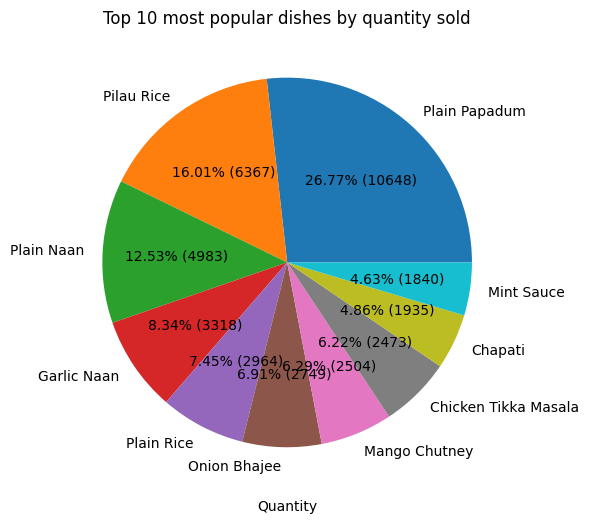

In [3]:
quantities = df.groupby(df.name)["quantity"].sum().sort_values(ascending=False)[:10]

quantities.plot.pie(
    subplots=True, 
    autopct=lambda p: "{:.2f}% ({:.0f})".format(p, (p / 100) * quantities.sum()),
    figsize=(10, 6),
)
plt.title("Top 10 most popular dishes by quantity sold")
plt.xlabel("Quantity")
plt.ylabel("")

plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

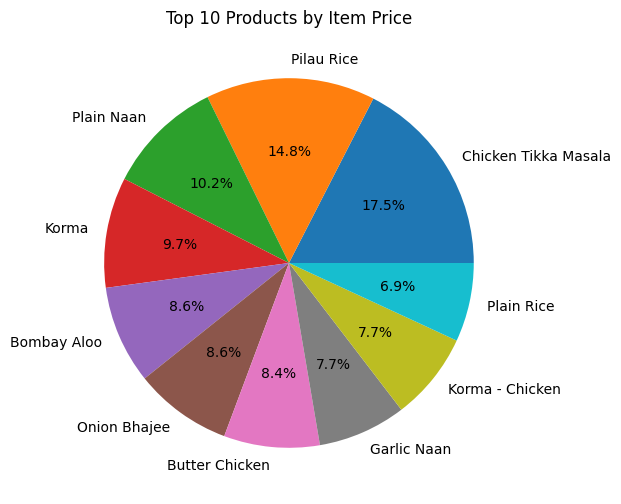

In [4]:
df["item_price"] = df["quantity"] * df["price"]
top_10_products_price = df.groupby("name")["item_price"].sum().nlargest(10)
plt.figure(figsize=(10, 6))
plt.pie(top_10_products_price, labels=top_10_products_price.index, autopct="%1.1f%%")
plt.title("Top 10 Products by Item Price")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

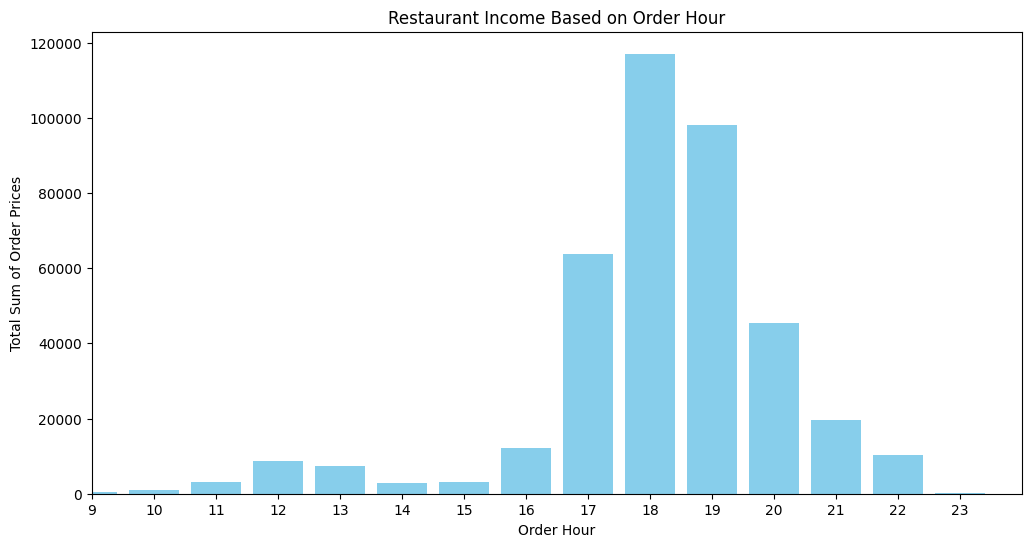

In [5]:
df["order_datetime"] = pd.to_datetime(df["datetime"])
df["order_hour"] = df["order_datetime"].dt.hour
hourly_income = df.groupby("order_hour")["price"].sum()

plt.figure(figsize=(12, 6))
plt.bar(hourly_income.index, hourly_income.values, color="skyblue")
plt.xlabel("Order Hour")
plt.ylabel("Total Sum of Order Prices")
plt.title("Restaurant Income Based on Order Hour")
plt.xticks(range(9, 24))
plt.xlim(9, 24)
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

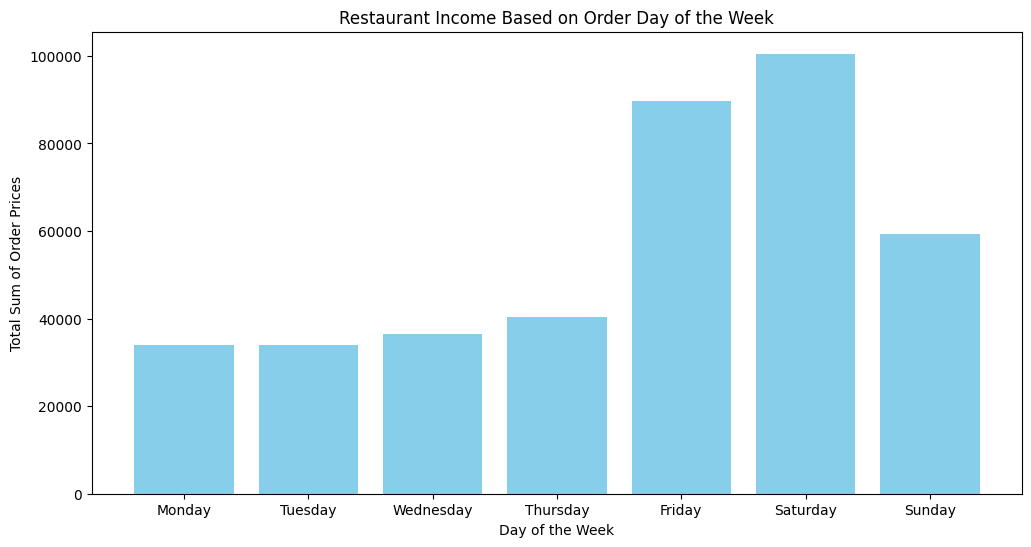

In [6]:
df["order_datetime"] = pd.to_datetime(df["order_datetime"])
df["order_day_of_week"] = df["order_datetime"].dt.dayofweek
daily_income = df.groupby("order_day_of_week")["price"].sum()

plt.figure(figsize=(12, 6))
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.bar(day_labels, daily_income.values, color="skyblue")
plt.xlabel("Day of the Week")
plt.ylabel("Total Sum of Order Prices")
plt.title("Restaurant Income Based on Order Day of the Week")
plt.show()